In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()
stats = importr('stats')

# 미션1

In [ ]:
raw_df = pd.read_excel('/content/drive/MyDrive/lsda02/data/customers.xlsx')
raw_df.head()

,CustID,Sex,Race,BirthDate,College,HouseholdSize,ZipCode,Income,Spending2017,Spending2018,NumOfOrders,DaysSinceLast,Satisfaction,Channel
0,1530016,Female,Black,1986-12-16,Yes,5,90047,53000,287,241,3,101,Very Dissatisfied,SM
1,1531136,Male,White,1993-05-09,Yes,5,90026,94000,1227,843,12,262,Neutral,TV
2,1532160,Male,Black,1966-05-22,Yes,2,90027,64000,523,719,9,122,Very Satisfied,TV
3,1532307,Male,White,1964-09-16,Yes,4,90029,60000,516,582,13,129,Very Dissatisfied,SM
4,1532356,Female,Hispanic,1964-07-15,No,5,90017,47000,555,845,7,97,Very Dissatisfied,Web


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustID         200 non-null    int64         
 1   Sex            200 non-null    object        
 2   Race           200 non-null    object        
 3   BirthDate      200 non-null    datetime64[ns]
 4   College        200 non-null    object        
 5   HouseholdSize  200 non-null    int64         
 6   ZipCode        200 non-null    int64         
 7   Income         200 non-null    int64         
 8   Spending2017   200 non-null    int64         
 9   Spending2018   200 non-null    int64         
 10  NumOfOrders    200 non-null    int64         
 11  DaysSinceLast  200 non-null    int64         
 12  Satisfaction   200 non-null    object        
 13  Channel        200 non-null    object        
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 22.0+ KB


In [ ]:
# 데이터 전처리할 사본 생성 - 문제가 생기면 원본으로 바로 재생성 가능하게
df = raw_df.copy()
df.head()

,CustID,Sex,Race,BirthDate,College,HouseholdSize,ZipCode,Income,Spending2017,Spending2018,NumOfOrders,DaysSinceLast,Satisfaction,Channel
0,1530016,Female,Black,1986-12-16,Yes,5,90047,53000,287,241,3,101,Very Dissatisfied,SM
1,1531136,Male,White,1993-05-09,Yes,5,90026,94000,1227,843,12,262,Neutral,TV
2,1532160,Male,Black,1966-05-22,Yes,2,90027,64000,523,719,9,122,Very Satisfied,TV
3,1532307,Male,White,1964-09-16,Yes,4,90029,60000,516,582,13,129,Very Dissatisfied,SM
4,1532356,Female,Hispanic,1964-07-15,No,5,90017,47000,555,845,7,97,Very Dissatisfied,Web


In [ ]:
# 대학교를 졸업한 1982년에서 1999년까지 태어난 고객의 데이터를 생성하세요.
df['College'].value_counts()

College
Yes    168
No      32
Name: count, dtype: int64

In [ ]:
print(df.query('College == "Yes"'))
print(df[df['College'] == 'Yes'])

      CustID     Sex             Race  BirthDate College  HouseholdSize  \
0    1530016  Female            Black 1986-12-16     Yes              5   
1    1531136    Male            White 1993-05-09     Yes              5   
2    1532160    Male            Black 1966-05-22     Yes              2   
3    1532307    Male            White 1964-09-16     Yes              4   
5    1532387    Male            White 1957-08-27     Yes              2   
..       ...     ...              ...        ...     ...            ...   
195  1578525    Male         Hispanic 1963-12-12     Yes              1   
196  1579349    Male            Asian 1980-12-19     Yes              1   
197  1579389  Female  American Indian 2000-05-21     Yes              1   
198  1579857  Female            White 1991-01-26     Yes              1   
199  1579979    Male            White 1999-07-05     Yes              5   

     ZipCode  Income  Spending2017  Spending2018  NumOfOrders  DaysSinceLast  \
0      90047   5300

In [ ]:
# 대학교 졸업한 사람
college = df[df['College'] == 'Yes']
college.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 199
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustID         168 non-null    int64         
 1   Sex            168 non-null    object        
 2   Race           168 non-null    object        
 3   BirthDate      168 non-null    datetime64[ns]
 4   College        168 non-null    object        
 5   HouseholdSize  168 non-null    int64         
 6   ZipCode        168 non-null    int64         
 7   Income         168 non-null    int64         
 8   Spending2017   168 non-null    int64         
 9   Spending2018   168 non-null    int64         
 10  NumOfOrders    168 non-null    int64         
 11  DaysSinceLast  168 non-null    int64         
 12  Satisfaction   168 non-null    object        
 13  Channel        168 non-null    object        
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 19.7+ KB


In [ ]:
# 1982~1999년 출생한 고객을 추출하기 위한 타임스탬프 생성
start_date = pd.to_datetime("1982-01-01")
start_date

Timestamp('1982-01-01 00:00:00')

In [ ]:
end_date = pd.to_datetime("1999-12-31")
end_date

Timestamp('1999-12-31 00:00:00')

In [ ]:
# 데이터[(조건1) & (조건2)]
college_8299 = college[(college['BirthDate'] >= start_date) & (college['BirthDate'] <= end_date)]
college_8299.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 199
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustID         59 non-null     int64         
 1   Sex            59 non-null     object        
 2   Race           59 non-null     object        
 3   BirthDate      59 non-null     datetime64[ns]
 4   College        59 non-null     object        
 5   HouseholdSize  59 non-null     int64         
 6   ZipCode        59 non-null     int64         
 7   Income         59 non-null     int64         
 8   Spending2017   59 non-null     int64         
 9   Spending2018   59 non-null     int64         
 10  NumOfOrders    59 non-null     int64         
 11  DaysSinceLast  59 non-null     int64         
 12  Satisfaction   59 non-null     object        
 13  Channel        59 non-null     object        
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 6.9+ KB


In [ ]:
# 한번에 만들어보자!
df = raw_df.copy()
start_date = pd.to_datetime("1982-01-01")
end_date = pd.to_datetime("1999-12-31")
college_8299 = df[(df['College'] == 'Yes') & (df['BirthDate'] >= start_date) & (df['BirthDate'] <= end_date)]
college_8299.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 199
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustID         59 non-null     int64         
 1   Sex            59 non-null     object        
 2   Race           59 non-null     object        
 3   BirthDate      59 non-null     datetime64[ns]
 4   College        59 non-null     object        
 5   HouseholdSize  59 non-null     int64         
 6   ZipCode        59 non-null     int64         
 7   Income         59 non-null     int64         
 8   Spending2017   59 non-null     int64         
 9   Spending2018   59 non-null     int64         
 10  NumOfOrders    59 non-null     int64         
 11  DaysSinceLast  59 non-null     int64         
 12  Satisfaction   59 non-null     object        
 13  Channel        59 non-null     object        
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 6.9+ KB


In [ ]:
# 여성
female = college_8299[college_8299['Sex'] == "Female"]
female.info()
female.to_csv("/content/drive/MyDrive/lsda02/data/female.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 0 to 198
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustID         21 non-null     int64         
 1   Sex            21 non-null     object        
 2   Race           21 non-null     object        
 3   BirthDate      21 non-null     datetime64[ns]
 4   College        21 non-null     object        
 5   HouseholdSize  21 non-null     int64         
 6   ZipCode        21 non-null     int64         
 7   Income         21 non-null     int64         
 8   Spending2017   21 non-null     int64         
 9   Spending2018   21 non-null     int64         
 10  NumOfOrders    21 non-null     int64         
 11  DaysSinceLast  21 non-null     int64         
 12  Satisfaction   21 non-null     object        
 13  Channel        21 non-null     object        
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 2.5+ KB


In [ ]:
# 남성
male = college_8299[college_8299['Sex'] == "Male"]
male.info()
male.to_csv("/content/drive/MyDrive/lsda02/data/male.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 1 to 199
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustID         38 non-null     int64         
 1   Sex            38 non-null     object        
 2   Race           38 non-null     object        
 3   BirthDate      38 non-null     datetime64[ns]
 4   College        38 non-null     object        
 5   HouseholdSize  38 non-null     int64         
 6   ZipCode        38 non-null     int64         
 7   Income         38 non-null     int64         
 8   Spending2017   38 non-null     int64         
 9   Spending2018   38 non-null     int64         
 10  NumOfOrders    38 non-null     int64         
 11  DaysSinceLast  38 non-null     int64         
 12  Satisfaction   38 non-null     object        
 13  Channel        38 non-null     object        
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 4.5+ KB


In [ ]:
# 한번에 해보자!
# 그룹 객체 => groupby(그룹화에 사용할 열)
college_8299_grouped_sex = college_8299.groupby(by = 'Sex')
college_8299_grouped_sex.get_group('Female').to_csv("/content/drive/MyDrive/lsda02/data/female.csv")
college_8299_grouped_sex.get_group('Male').to_csv("/content/drive/MyDrive/lsda02/data/male.csv")

# 미션2

In [ ]:
# 미션 1에서 만든 대학교 졸업한 82년~99년 출생 고객의 데이터를 이용
# Sex, Race, HouseholdSize, Income, Satisfaction, Channel 변수를 선택하여 desc_df로 저장
selected_columns = ['Sex', 'Race', 'HouseholdSize', 'Income', 'Satisfaction', 'Channel']
desc_df = college_8299[selected_columns]
desc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 0 to 199
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sex            59 non-null     object
 1   Race           59 non-null     object
 2   HouseholdSize  59 non-null     int64 
 3   Income         59 non-null     int64 
 4   Satisfaction   59 non-null     object
 5   Channel        59 non-null     object
dtypes: int64(2), object(4)
memory usage: 3.2+ KB


In [ ]:
# desc_df를 이용하여 남녀 차이를 보기 위한 기술통계표를 작성하세요.
print(pd.crosstab(desc_df.Race, desc_df.Sex))
print("\n")
print(pd.crosstab(desc_df.HouseholdSize, desc_df.Sex))
print("\n")
print("Female: ", pd.DataFrame(desc_df[desc_df.Sex == "Female"].Income.describe().loc[["mean", "std"]]).T)
print("Male: ", pd.DataFrame(desc_df[desc_df.Sex == "Male"].Income.describe().loc[["mean", "std"]]).T)
print("\n")
print(pd.crosstab(desc_df.Satisfaction, desc_df.Sex))
print("\n")
print(pd.crosstab(desc_df.Channel, desc_df.Sex))

Sex               Female  Male
Race                          
American Indian        0     2
Asian                  0     4
Black                  7     6
Hispanic               4     8
Pacific Islander       0     1
White                 10    17


Sex            Female  Male
HouseholdSize              
1                   4     6
2                   4     7
3                   5     9
4                   2     8
5                   6     8


Female:                  mean           std
Income  61285.714286  19680.301972
Male:                  mean          std
Income  83157.894737  27514.64113


Sex                    Female  Male
Satisfaction                       
Neutral                     1     6
Somewhat Dissatisfied       3     3
Somewhat Satisfied         11    21
Very Dissatisfied           2     2
Very Satisfied              4     6


Sex       Female  Male
Channel               
Referral       6     6
SM             3    16
TV             4     9
Web            8     7


In [ ]:
desc_df.Income.describe()

count        59.000000
mean      75372.881356
std       26982.688131
min       34000.000000
25%       55000.000000
50%       69000.000000
75%       94000.000000
max      167000.000000
Name: Income, dtype: float64

In [ ]:
desc_df.Income.describe().loc[["mean", "std"]]

mean    75372.881356
std     26982.688131
Name: Income, dtype: float64

In [ ]:
# t검정
female_income = desc_df.query('Sex == "Female"')['Income']
male_income = desc_df.query('Sex == "Male"')['Income']
tv, pv = ttest_ind(female_income, male_income, equal_var = True)
print("t-statitics: ", round(tv, 5))
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")

t-statitics:  -3.21161
p-value:  0.00217
significant


In [ ]:
# 카이제곱검정
tab = pd.crosstab(desc_df.Race, desc_df.Sex)
print(tab)
print("\n")
print(chi2_contingency(tab))
print("\n")
result = chi2_contingency(tab)
chiv = result[0]
pv = result[1]
print("chi2-statitics: ", round(chiv, 5))
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")
print("expected frequency")
print(result[3])
f_pct = ((result[3] < 5).sum() / (result[3].shape[0] * result[3].shape[1])) * 100
print(str(round(f_pct,2)) + "%")
if f_pct >= 20:
  print("Fisher Exact Test!")
else:
  print("No Fisher Exact Test!")

Sex               Female  Male
Race                          
American Indian        0     2
Asian                  0     4
Black                  7     6
Hispanic               4     8
Pacific Islander       0     1
White                 10    17


Chi2ContingencyResult(statistic=5.809045405536633, pvalue=0.32524532718433313, dof=5, expected_freq=array([[ 0.71186441,  1.28813559],
       [ 1.42372881,  2.57627119],
       [ 4.62711864,  8.37288136],
       [ 4.27118644,  7.72881356],
       [ 0.3559322 ,  0.6440678 ],
       [ 9.61016949, 17.38983051]]))


chi2-statitics:  5.80905
p-value:  0.32525
not significant
expected frequency
[[ 0.71186441  1.28813559]
 [ 1.42372881  2.57627119]
 [ 4.62711864  8.37288136]
 [ 4.27118644  7.72881356]
 [ 0.3559322   0.6440678 ]
 [ 9.61016949 17.38983051]]
66.67%
Fisher Exact Test!


In [ ]:
# 피셔 정확 검정
tab = np.array(tab)
result = stats.fisher_test(tab)
print(result)
print(result[0])
pv = result[0][0]
print(pv)
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")


	Fisher's Exact Test for Count Data

data:  structure(c(0L, 0L, 7L, 4L, 0L, 10L, 2L, 4L, 6L, 8L, 1L, 17L), dim = c(6L, 2L))
p-value = 0.4008
alternative hypothesis: two.sided


[1] 0.400762

0.400761953244126
p-value:  0.40076
not significant


In [ ]:
tab = pd.crosstab(desc_df.HouseholdSize, desc_df.Sex)
print(tab)
print("\n")
print(chi2_contingency(tab))
print("\n")
result = chi2_contingency(tab)
chiv = result[0]
pv = result[1]
print("chi2-statitics: ", round(chiv, 5))
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")
print("expected frequency")
print(result[3])
f_pct = ((result[3] < 5).sum() / (result[3].shape[0] * result[3].shape[1])) * 100
print(str(round(f_pct,2)) + "%")
if f_pct >= 20:
  print("Fisher Exact Test!")
else:
  print("No Fisher Exact Test!")

Sex            Female  Male
HouseholdSize              
1                   4     6
2                   4     7
3                   5     9
4                   2     8
5                   6     8


Chi2ContingencyResult(statistic=1.4705351039937513, pvalue=0.8318476716826708, dof=4, expected_freq=array([[3.55932203, 6.44067797],
       [3.91525424, 7.08474576],
       [4.98305085, 9.01694915],
       [3.55932203, 6.44067797],
       [4.98305085, 9.01694915]]))


chi2-statitics:  1.47054
p-value:  0.83185
not significant
expected frequency
[[3.55932203 6.44067797]
 [3.91525424 7.08474576]
 [4.98305085 9.01694915]
 [3.55932203 6.44067797]
 [4.98305085 9.01694915]]
50.0%
Fisher Exact Test!


In [ ]:
tab = np.array(tab)
result = stats.fisher_test(tab)
print(result)
print(result[0])
pv = result[0][0]
print(pv)
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")


	Fisher's Exact Test for Count Data

data:  structure(c(4L, 4L, 5L, 2L, 6L, 6L, 7L, 9L, 8L, 8L), dim = c(5L, 2L))
p-value = 0.8503
alternative hypothesis: two.sided


[1] 0.850317

0.8503170108227862
p-value:  0.85032
not significant


In [ ]:
tab = pd.crosstab(desc_df.Satisfaction, desc_df.Sex)
print(tab)
print("\n")
print(chi2_contingency(tab))
print("\n")
result = chi2_contingency(tab)
chiv = result[0]
pv = result[1]
print("chi2-statitics: ", round(chiv, 5))
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")
print("expected frequency")
print(result[3])
f_pct = ((result[3] < 5).sum() / (result[3].shape[0] * result[3].shape[1])) * 100
print(str(round(f_pct,2)) + "%")
if f_pct >= 20:
  print("Fisher Exact Test!")
else:
  print("No Fisher Exact Test!")

Sex                    Female  Male
Satisfaction                       
Neutral                     1     6
Somewhat Dissatisfied       3     3
Somewhat Satisfied         11    21
Very Dissatisfied           2     2
Very Satisfied              4     6


Chi2ContingencyResult(statistic=2.397139052989616, pvalue=0.663144348129268, dof=4, expected_freq=array([[ 2.49152542,  4.50847458],
       [ 2.13559322,  3.86440678],
       [11.38983051, 20.61016949],
       [ 1.42372881,  2.57627119],
       [ 3.55932203,  6.44067797]]))


chi2-statitics:  2.39714
p-value:  0.66314
not significant
expected frequency
[[ 2.49152542  4.50847458]
 [ 2.13559322  3.86440678]
 [11.38983051 20.61016949]
 [ 1.42372881  2.57627119]
 [ 3.55932203  6.44067797]]
70.0%
Fisher Exact Test!


In [ ]:
tab = np.array(tab)
result = stats.fisher_test(tab)
print(result)
print(result[0])
pv = result[0][0]
print(pv)
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")


	Fisher's Exact Test for Count Data

data:  structure(c(1L, 3L, 11L, 2L, 4L, 6L, 3L, 21L, 2L, 6L), dim = c(5L, 2L))
p-value = 0.6617
alternative hypothesis: two.sided


[1] 0.6617458

0.6617457992615556
p-value:  0.66175
not significant


In [ ]:
tab = pd.crosstab(desc_df.Channel, desc_df.Sex)
print(tab)
print("\n")
print(chi2_contingency(tab))
print("\n")
result = chi2_contingency(tab)
chiv = result[0]
pv = result[1]
print("chi2-statitics: ", round(chiv, 5))
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")
print("expected frequency")
print(result[3])
f_pct = ((result[3] < 5).sum() / (result[3].shape[0] * result[3].shape[1])) * 100
print(str(round(f_pct,2)) + "%")
if f_pct >= 20:
  print("Fisher Exact Test!")
else:
  print("No Fisher Exact Test!")

Sex       Female  Male
Channel               
Referral       6     6
SM             3    16
TV             4     9
Web            8     7


Chi2ContingencyResult(statistic=6.528156761674767, pvalue=0.08855866046491273, dof=3, expected_freq=array([[ 4.27118644,  7.72881356],
       [ 6.76271186, 12.23728814],
       [ 4.62711864,  8.37288136],
       [ 5.33898305,  9.66101695]]))


chi2-statitics:  6.52816
p-value:  0.08856
not significant
expected frequency
[[ 4.27118644  7.72881356]
 [ 6.76271186 12.23728814]
 [ 4.62711864  8.37288136]
 [ 5.33898305  9.66101695]]
25.0%
Fisher Exact Test!


In [ ]:
tab = np.array(tab)
result = stats.fisher_test(tab)
print(result)
print(result[0])
pv = result[0][0]
print(pv)
print("p-value: ", round(pv, 5))
if pv < 0.05:
  print("significant")
else:
  print("not significant")


	Fisher's Exact Test for Count Data

data:  structure(c(6L, 3L, 4L, 8L, 6L, 16L, 9L, 7L), dim = c(4L, 2L))
p-value = 0.08059
alternative hypothesis: two.sided


[1] 0.08059186

0.08059185685217439
p-value:  0.08059
not significant


# 데이터 분석 프로젝트

## 한국복지패널 데이터 분석 준비하기

In [ ]:
# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 메뉴 - 런타임 - 세션 다시 시작

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (18.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121753 files and direc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# 한글 폰트 지정
plt.rc("font", family = "NanumGothic")

In [ ]:
# 데이터 불러오기
raw_welfare = pd.read_csv('/content/drive/MyDrive/lsda02/data/welfare_2015.csv')

In [ ]:
# 복사본 만들기
welfare = raw_welfare.copy()

In [ ]:
# 데이터 앞부분, 뒷부분 출력
print(welfare)
print(welfare.head())
print(welfare.tail())

       h10_g3  h10_g4  h10_g10  h10_g11  h10_eco9  p1002_8aq1  h10_reg7
0           2    1936        2        2       NaN         NaN         1
1           2    1945        2        2       NaN         NaN         1
2           1    1948        2        2     942.0       120.0         1
3           1    1942        3        1     762.0       200.0         1
4           2    1923        2        1       NaN         NaN         1
...       ...     ...      ...      ...       ...         ...       ...
16665       2    9999        5        1       NaN         NaN         6
16666       1    1972        9        1       NaN         NaN         6
16667       2    1969        1        9       NaN         NaN         2
16668       2    1960        3        2    9999.0         NaN         6
16669       1    1940        1        1       NaN      9999.0         5

[16670 rows x 7 columns]
   h10_g3  h10_g4  h10_g10  h10_g11  h10_eco9  p1002_8aq1  h10_reg7
0       2    1936        2        2       

In [ ]:
welfare.shape       # 행, 열 개수 출력

(16670, 7)

In [ ]:
welfare.info()      # 변수 속성 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   h10_g3      16670 non-null  int64  
 1   h10_g4      16670 non-null  int64  
 2   h10_g10     16670 non-null  int64  
 3   h10_g11     16670 non-null  int64  
 4   h10_eco9    7530 non-null   float64
 5   p1002_8aq1  4635 non-null   float64
 6   h10_reg7    16670 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 911.8 KB


In [ ]:
welfare.describe()  # 요약 통계량

,h10_g3,h10_g4,h10_g10,h10_g11,h10_eco9,p1002_8aq1,h10_reg7
count,16670.000000,16670.000000,16670.000000,16670.000000,7530.000000,4635.000000,16670.000000
mean,1.545711,1968.047391,1.648410,1.517516,592.493094,243.724168,3.705099
std,0.501283,66.738241,1.572843,0.503058,277.804427,233.549988,2.069236
min,1.000000,1907.000000,0.000000,1.000000,111.000000,0.000000,1.000000
25%,1.000000,1946.000000,1.000000,1.000000,314.000000,122.000000,2.000000
50%,2.000000,1966.000000,1.000000,2.000000,611.000000,192.500000,3.000000
75%,2.000000,1988.000000,2.000000,2.000000,863.000000,316.650000,6.000000
max,9.000000,9999.000000,9.000000,9.000000,9999.000000,9999.000000,7.000000


In [ ]:
welfare = welfare.rename(columns={'h10_g3':'sex', #  성별
                                  'h10_g4':'birth_year', #  태어난 연도
                                  'h10_g10':'marital_status', #  혼인 상태
                                  'h10_g11':'religion', #  종교
                                  'h10_eco9':'job_code', #  월급
                                  'p1002_8aq1':'income', #  직업 코드
                                  'h10_reg7':'region_code'}) #  지역 코드

In [ ]:
welfare.head()

,sex,birth_year,marital_status,religion,job_code,income,region_code
0,2,1936,2,2,NaN,NaN,1
1,2,1945,2,2,NaN,NaN,1
2,1,1948,2,2,942.0,120.0,1
3,1,1942,3,1,762.0,200.0,1
4,2,1923,2,1,NaN,NaN,1


## 1 성별에 따른 월급 차이 - '성별에 따라 월급이 다를까?'

### 성별 변수 검토 및 전처리하기

#### 1. 변수 검토하기

In [ ]:
welfare['sex'].dtypes  # 변수 타입 출력

dtype('int64')

In [ ]:
welfare['sex'].value_counts()  # 빈도 구하기

sex
2    9089
1    7580
9       1
Name: count, dtype: int64

#### 2. 전처리

In [ ]:
# 이상치 확인
welfare['sex'].value_counts(dropna = False)
# 9 => 코드북 상으로 모름/무응답(미상)

sex
2    9089
1    7580
9       1
Name: count, dtype: int64

In [ ]:
# 이상치 결측 처리
welfare['sex'] = np.where(welfare['sex'] == 9, np.nan, welfare['sex'])

In [ ]:
# 이상치, 결측치 확인
welfare['sex'].value_counts(dropna = False)

sex
2.0    9089
1.0    7580
NaN       1
Name: count, dtype: int64

In [ ]:
# 결측치 확인
welfare['sex'].isnull().sum()

1

In [ ]:
# 성별 항목 이름 부여
welfare['sex'] = np.where(welfare['sex'] == 1, 'male',
                          np.where(welfare['sex'] == 2, 'female', np.nan))

In [ ]:
# 빈도 구하기
welfare['sex'].value_counts(dropna = False)

sex
female    9089
male      7580
nan          1
Name: count, dtype: int64

In [ ]:
#  nan 문자열을 NaN 으로 변환
welfare['sex'] = np.where(welfare['sex'] == 'nan', np.nan, welfare['sex'])

In [ ]:
# 빈도 구하기
welfare['sex'].value_counts(dropna = False)

sex
female    9089
male      7580
NaN          1
Name: count, dtype: int64

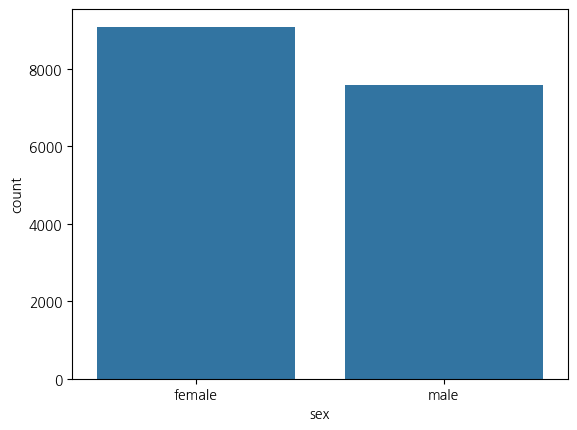

In [ ]:
# 빈도 막대 그래프 만들기
sns.countplot(x = 'sex', data = welfare)
plt.show()

### 월급 변수 검토 및 전처리하기

#### 1. 변수 검토하기

In [ ]:
welfare['income'].dtypes  # 변수 타입 출력

dtype('float64')

In [ ]:
welfare['income'].describe()  # 요약 통계량 구하기

count    4635.000000
mean      243.724168
std       233.549988
min         0.000000
25%       122.000000
50%       192.500000
75%       316.650000
max      9999.000000
Name: income, dtype: float64

#### 2. 전처리


In [ ]:
welfare['income'].describe()  # 이상치 확인
# 월급이 0 => 소득이 없음
# 월급이 9999 => 코드북 상으로 모름/무응답(미상)

count    4635.000000
mean      243.724168
std       233.549988
min         0.000000
25%       122.000000
50%       192.500000
75%       316.650000
max      9999.000000
Name: income, dtype: float64

In [ ]:
welfare['income'].isnull().sum()  # 결측치 확인

12035

In [ ]:
# 빈도 구하기
welfare['income'].value_counts(dropna = False)

income
NaN        12035
20.00        136
150.00       128
200.00        91
250.00        74
           ...  
392.70         1
515.00         1
397.18         1
304.16         1
9999.00        1
Name: count, Length: 1769, dtype: int64

In [ ]:
# 이상치 결측 처리 - 9999
welfare['income'] = np.where(welfare['income'] == 9999, np.nan, welfare['income'])

In [ ]:
# 결측치 확인
welfare['income'].isnull().sum()

12036

In [ ]:
# 빈도 구하기
welfare['income'].value_counts(dropna = False)

income
NaN       12036
20.00       136
150.00      128
200.00       91
250.00       74
          ...  
515.00        1
397.18        1
304.16        1
487.50        1
187.66        1
Name: count, Length: 1768, dtype: int64

In [ ]:
welfare['income'].describe()  # 이상치 확인

count    4634.000000
mean      241.619016
std       184.423869
min         0.000000
25%       122.000000
50%       192.500000
75%       316.600000
max      2400.000000
Name: income, dtype: float64

In [ ]:
# 이상치 결측 처리 - 0
welfare['income'] = np.where(welfare['income'] == 0, np.nan, welfare['income'])

In [ ]:
# 결측치 확인
welfare['income'].isnull().sum()

12050

In [ ]:
# 빈도 구하기
welfare['income'].value_counts(dropna = False)

income
NaN       12050
20.00       136
150.00      128
200.00       91
250.00       74
          ...  
515.00        1
397.18        1
304.16        1
487.50        1
187.66        1
Name: count, Length: 1767, dtype: int64

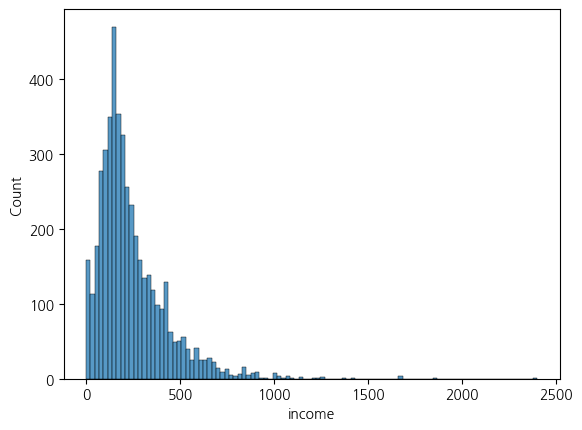

In [ ]:
sns.histplot(x = 'income', data = welfare)  # 히스토그램 만들기
plt.show()

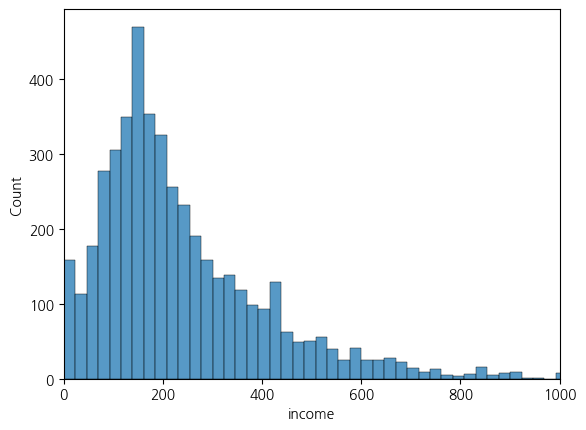

In [ ]:
# 평균 월급 천만원 이내에 많이 모여 있으므로 자세히 보기 위해 축 범위 변경
sns.histplot(x = 'income', data = welfare).set(xlim = (0,1000))  # 히스토그램 만들기
plt.show()

### 성별에 따른 월급 차이 분석하기

#### 1. 성별 월급 평균표 만들기

In [ ]:
welfare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             16669 non-null  object 
 1   birth_year      16670 non-null  int64  
 2   marital_status  16670 non-null  int64  
 3   religion        16670 non-null  int64  
 4   job_code        7530 non-null   float64
 5   income          4620 non-null   float64
 6   region_code     16670 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 911.8+ KB


In [ ]:
welfare.dropna(subset = ['sex','income'])

,sex,birth_year,marital_status,religion,job_code,income,region_code
2,male,1948,2,2,942.0,120.00,1
3,male,1942,3,1,762.0,200.00,1
18,male,1962,5,2,999.0,40.00,1
19,male,1978,1,2,312.0,350.00,1
20,female,1975,1,2,254.0,200.00,1
...,...,...,...,...,...,...,...
16639,male,1956,3,1,873.0,162.00,6
16642,male,1966,1,1,873.0,188.00,6
16643,female,1962,1,1,899.0,90.00,6
16654,male,1956,1,2,743.0,187.66,6


In [ ]:
# 하나씩 해보자!
sex_income_test = welfare.dropna(subset = ['sex','income'])

In [ ]:
sex_income_test.sex.value_counts(dropna=False)

sex
male      2452
female    2168
Name: count, dtype: int64

In [ ]:
sex_income_test.income.describe()

count    4620.000000
mean      242.351195
std       184.222067
min         0.460000
25%       123.000000
50%       193.000000
75%       316.700000
max      2400.000000
Name: income, dtype: float64

In [ ]:
sex_income_test.income.value_counts(dropna=False)

income
20.00     136
150.00    128
200.00     91
250.00     74
120.00     71
         ... 
515.00      1
397.18      1
304.16      1
487.50      1
187.66      1
Name: count, Length: 1766, dtype: int64

In [ ]:
# as_index = True => 그룹 이름을 행 인덱스로 사용
grouped = sex_income_test.groupby('sex')
print(grouped.agg({'income': 'mean'}))
print(grouped.agg({'income': ['mean','std']}))
grouped.agg(mean_income = ('income', 'mean'), sd_income = ('income', 'std')) # 튜플 형태

            income
sex               
female  163.247085
male    312.293165
            income            
              mean         std
sex                           
female  163.247085  126.053981
male    312.293165  198.694969


,mean_income,sd_income
sex,,
female,163.247085,126.053981
male,312.293165,198.694969


In [ ]:
# as_index = False => 그룹 이름을 행 인덱스로 사용하지 않게 설정
grouped = sex_income_test.groupby('sex', as_index = False)
print(grouped.agg({'income': 'mean'}))
print(grouped.agg({'income': ['mean','std']}))
grouped.agg(mean_income = ('income', 'mean'), sd_income = ('income', 'std')) # 튜플 형태

      sex      income
0  female  163.247085
1    male  312.293165
      sex      income            
                 mean         std
0  female  163.247085  126.053981
1    male  312.293165  198.694969


,sex,mean_income,sd_income
0,female,163.247085,126.053981
1,male,312.293165,198.694969


In [ ]:
# 하나씩 한 내용 종합하여 한번에 처리

# 성별 월급 평균표 만들기
# 그룹 이름을 행 인덱스로 사용하지 않게 설정
sex_income = welfare.dropna(subset = ['sex','income']). \
                     groupby('sex', as_index = False). \
                     agg(mean_income = ('income', 'mean'))
sex_income
# income 결측치 제거
# sex별 분리
# income 평균 구하기

,sex,mean_income
0,female,163.247085
1,male,312.293165


In [ ]:
sex_income_diff = sex_income.iloc[1,1] - sex_income.iloc[0,1]
sex_income_diff

149.04607989260967

#### 2. 그래프 만들기

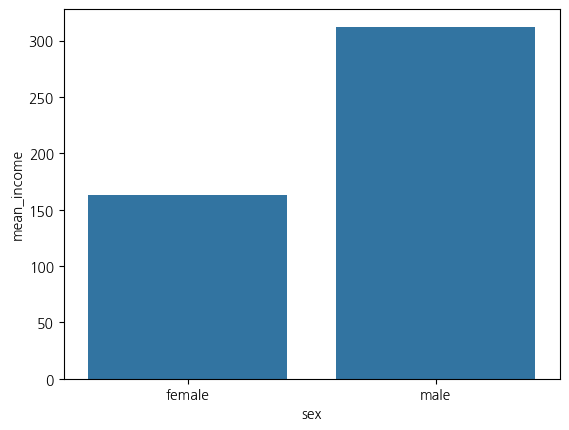

In [ ]:
# 막대 그래프 만들기
sns.barplot(x = 'sex', y = 'mean_income', data = sex_income)
plt.show()
# 추가 분석 진행 - 독립표본 t검정 & 유의확률

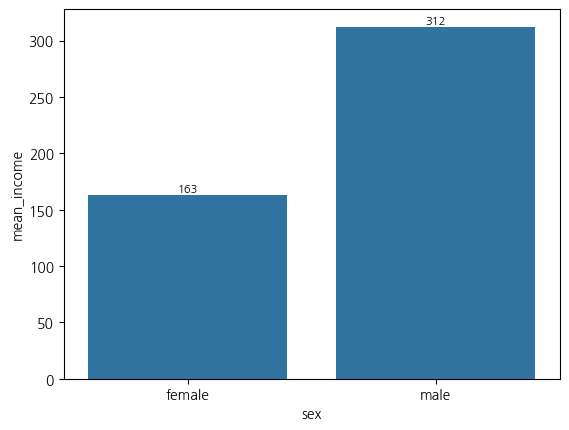

In [ ]:
# 막대 그래프 만들기
sns.barplot(x = 'sex', y = 'mean_income', data = sex_income)
for i, j in enumerate(sex_income["mean_income"]):
  plt.annotate(round(j), (i, j), xytext = (0, 2), textcoords = 'offset points', fontsize = 8, ha = 'center', color = 'black')
plt.show()

# 중간 데이터 저장

In [ ]:
welfare.to_csv('/content/drive/MyDrive/lsda02/data/welfare_2015_0408.csv', index = False)

In [ ]:
# 데이터 불러오기
welfare = pd.read_csv('/content/drive/MyDrive/lsda02/data/welfare_2015_0408.csv')

## 2 나이와 월급의 관계 - '몇 살 때 월급을 가장 많이 받을까?'

### 나이 변수 검토 및 전처리하기

#### 1. 변수 검토하기

In [ ]:
welfare['birth_year'].dtypes  # 변수 타입 출력

dtype('int64')

In [ ]:
welfare['birth_year'].describe()  # 요약 통계량 구하기

count    16670.000000
mean      1968.047391
std         66.738241
min       1907.000000
25%       1946.000000
50%       1966.000000
75%       1988.000000
max       9999.000000
Name: birth_year, dtype: float64

In [ ]:
# 빈도 구하기
welfare['birth_year'].value_counts(dropna = False)

birth_year
1942    354
1939    300
1940    294
1938    279
1947    269
       ... 
1914      1
1911      1
1917      1
1915      1
9999      1
Name: count, Length: 103, dtype: int64

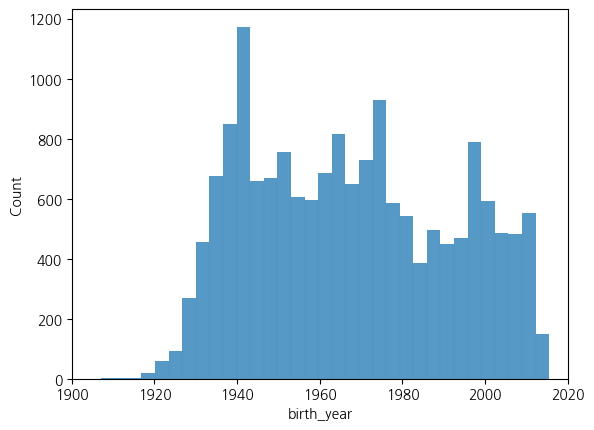

In [ ]:
sns.histplot(x = 'birth_year', data = welfare).set(xlim = (1900,2020))  # 히스토그램 만들기
plt.show()

#### 2. 전처리

In [ ]:
welfare['birth_year'].describe()  # 이상치 확인
# 9999 => 코드북 상으로 모름/무응답(미상)

count    16670.000000
mean      1968.047391
std         66.738241
min       1907.000000
25%       1946.000000
50%       1966.000000
75%       1988.000000
max       9999.000000
Name: birth_year, dtype: float64

In [ ]:
welfare['birth_year'].isnull().sum()  # 결측치 확인

0

In [ ]:
# 빈도 구하기
welfare['birth_year'].value_counts(dropna = False)

birth_year
1942    354
1939    300
1940    294
1938    279
1947    269
       ... 
1914      1
1911      1
1917      1
1915      1
9999      1
Name: count, Length: 103, dtype: int64

In [ ]:
# 이상치 결측 처리
welfare['birth_year'] = np.where(welfare['birth_year'] == 9999, np.nan, welfare['birth_year'])

In [ ]:
# 결측치 확인
welfare['birth_year'].isnull().sum()

1

In [ ]:
# 빈도 구하기
welfare['birth_year'].value_counts(dropna = False)

birth_year
1942.0    354
1939.0    300
1940.0    294
1938.0    279
1947.0    269
         ... 
1914.0      1
1911.0      1
1917.0      1
1915.0      1
NaN         1
Name: count, Length: 103, dtype: int64

In [ ]:
welfare['birth_year'].describe()  # 이상치 확인

count    16669.000000
mean      1967.565601
std         24.177789
min       1907.000000
25%       1946.000000
50%       1966.000000
75%       1988.000000
max       2014.000000
Name: birth_year, dtype: float64

#### 3. 파생변수 만들기 - 나이

In [ ]:
welfare['age'] = 2015 - welfare['birth_year'] + 1

In [ ]:
welfare.head()

,sex,birth_year,marital_status,religion,job_code,income,region_code,age
0,female,1936.0,2,2,NaN,NaN,1,80.0
1,female,1945.0,2,2,NaN,NaN,1,71.0
2,male,1948.0,2,2,942.0,120.0,1,68.0
3,male,1942.0,3,1,762.0,200.0,1,74.0
4,female,1923.0,2,1,NaN,NaN,1,93.0


In [ ]:
# 결측치 확인
welfare['age'].isnull().sum()

1

In [ ]:
# 빈도 구하기
welfare['age'].value_counts(dropna = False)

age
74.0     354
77.0     300
76.0     294
78.0     279
69.0     269
        ... 
102.0      1
105.0      1
99.0       1
101.0      1
NaN        1
Name: count, Length: 103, dtype: int64

In [ ]:
welfare['age'].describe() # 요약 통계량 구하기

count    16669.000000
mean        48.434399
std         24.177789
min          2.000000
25%         28.000000
50%         50.000000
75%         70.000000
max        109.000000
Name: age, dtype: float64

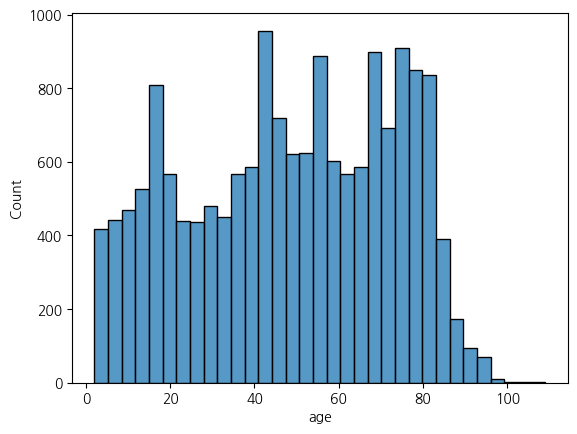

In [ ]:
sns.histplot(x = 'age', data = welfare)  # 히스토그램 만들기
plt.show()

### 나이와 월급의 관계 분석하기

#### 1. 나이에 따른 월급 평균표 만들기

In [ ]:
welfare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             16669 non-null  object 
 1   birth_year      16669 non-null  float64
 2   marital_status  16670 non-null  int64  
 3   religion        16670 non-null  int64  
 4   job_code        7530 non-null   float64
 5   income          4620 non-null   float64
 6   region_code     16670 non-null  int64  
 7   age             16669 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [ ]:
# 나이별 월급 평균표 만들기
age_income = welfare.dropna(subset = ['age','income']) \
                    .groupby('age', as_index = False) \
                    .agg(mean_income = ('income', 'mean'))
# 결측치 제거
# age별 분리
# income 평균 구하기
age_income.head()

,age,mean_income
0,20.0,121.300000
1,21.0,105.518519
2,22.0,130.092258
3,23.0,141.715652
4,24.0,134.087736


In [ ]:
# 평균 월급 최대값 나이 확인
max_age_income = age_income.mean_income.max()
print(max_age_income)
age_income[age_income['mean_income'] == max_age_income]
# age_income[age_income.mean_income == age_income.mean_income.max()]

318.6777477477478


,age,mean_income
33,53.0,318.677748


In [ ]:
max_age_income_index = np.argmax(age_income['mean_income'])
print(max_age_income_index)
age_income.iloc[max_age_income_index,:]

33


age             53.000000
mean_income    318.677748
Name: 33, dtype: float64

#### 2.  그래프 만들기

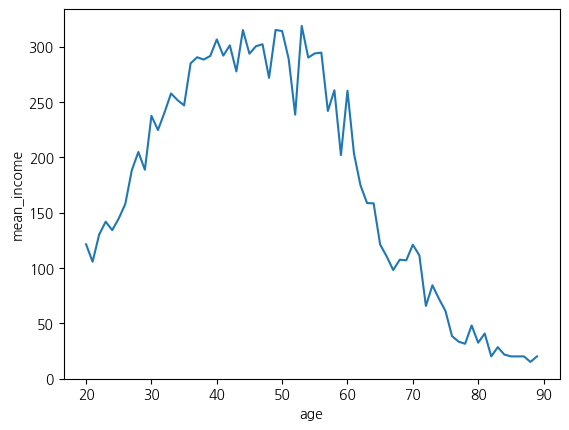

In [ ]:
# 선 그래프 만들기
sns.lineplot(x = 'age', y = 'mean_income', data = age_income)
plt.show()

# 중간 데이터 저장

In [ ]:
welfare.to_csv('/content/drive/MyDrive/lsda02/data/welfare_2015_0408.csv', index = False)

In [ ]:
# 데이터 불러오기
welfare = pd.read_csv('/content/drive/MyDrive/lsda02/data/welfare_2015_0408.csv')

## 3 연령대에 따른 월급 차이 - 어떤 연령대의 월급이 가장 많을까?


### 연령대 변수 검토 및 전처리하기

#### 파생변수 만들기 - 연령대

In [ ]:
# 나이 변수 살펴보기
welfare['age'].head()

0    80.0
1    71.0
2    68.0
3    74.0
4    93.0
Name: age, dtype: float64

In [ ]:
welfare['age'].describe() # 요약 통계량 구하기

count    16669.000000
mean        48.434399
std         24.177789
min          2.000000
25%         28.000000
50%         50.000000
75%         70.000000
max        109.000000
Name: age, dtype: float64

In [ ]:
# 결측치 확인
welfare['age'].isnull().sum()

1

In [ ]:
# 빈도 구하기
welfare['age'].value_counts(dropna = False)

age
74.0     354
77.0     300
76.0     294
78.0     279
69.0     269
        ... 
102.0      1
105.0      1
99.0       1
101.0      1
NaN        1
Name: count, Length: 103, dtype: int64

In [ ]:
# 연령대 변수 만들기
# 60 세 이상 = old
# 30 ~ 59 세 = middle
# ~ 29 세 = young
welfare['age_group'] = np.where(welfare['age'].isnull() == True, np.nan,
                                np.where(welfare['age'] >=  60, 'old',
                                         np.where(welfare['age'] >= 30, 'middle', 'young')))

In [ ]:
# 빈도 구하기
welfare['age_group'].value_counts(dropna = False)

age_group
old       6283
middle    6052
young     4334
nan          1
Name: count, dtype: int64

In [ ]:
# 결측치 확인
welfare['age_group'].isnull().sum()

0

In [ ]:
# 문자열 nan 을 NaN 으로 변환
welfare['age_group'] = np.where(welfare['age_group'] == 'nan', np.nan, welfare['age_group'])

In [ ]:
# 결측치 확인
welfare['age_group'].isnull().sum()

1

In [ ]:
# 빈도 구하기
welfare['age_group'].value_counts(dropna = False)

age_group
old       6283
middle    6052
young     4334
NaN          1
Name: count, dtype: int64

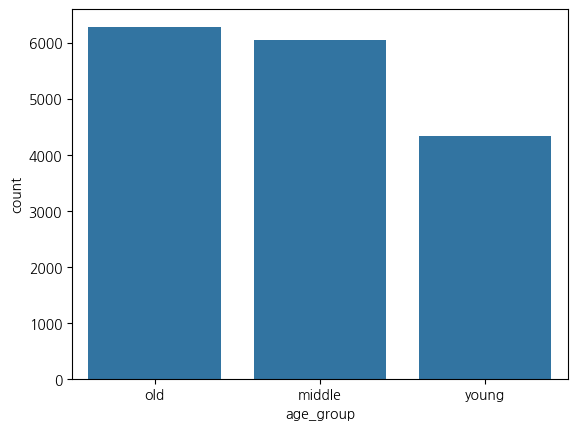

In [ ]:
# 빈도 막대 그래프 만들기
sns.countplot(x = 'age_group', data = welfare)
plt.show()

### 연령대에 따른 월급 차이 분석하기

#### 1. 연령대별 월급 평균표 만들기

In [ ]:
welfare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16670 entries, 0 to 16669
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             16669 non-null  object 
 1   birth_year      16669 non-null  float64
 2   marital_status  16670 non-null  int64  
 3   religion        16670 non-null  int64  
 4   job_code        7530 non-null   float64
 5   income          4620 non-null   float64
 6   region_code     16670 non-null  int64  
 7   age             16669 non-null  float64
 8   age_group       16669 non-null  object 
dtypes: float64(4), int64(3), object(2)
memory usage: 1.1+ MB


In [ ]:
# 연령대별 월급 평균표 만들기
age_group_income = welfare.dropna(subset = ['age_group','income']) \
                     .groupby('age_group', as_index = False) \
                     .agg(mean_income = ('income', 'mean'))
# 결측치 제거
# age_group 별 분리
# income 평균 구하기
age_group_income

,age_group,mean_income
0,middle,281.887100
1,old,125.329463
2,young,163.595331


In [ ]:
# middle 과 old 의 평균 월급 차이
print(age_group_income.iloc[0,1] - age_group_income.iloc[1,1])
# middle 과 young 의 평균 월급 차이
print(age_group_income.iloc[0,1] - age_group_income.iloc[2,1])
# young 과 old 의 평균 월급 차이
print(age_group_income.iloc[2,1] - age_group_income.iloc[1,1])

156.55763727873892
118.29176987126272
38.26586740747621


#### 2. 그래프 만들기

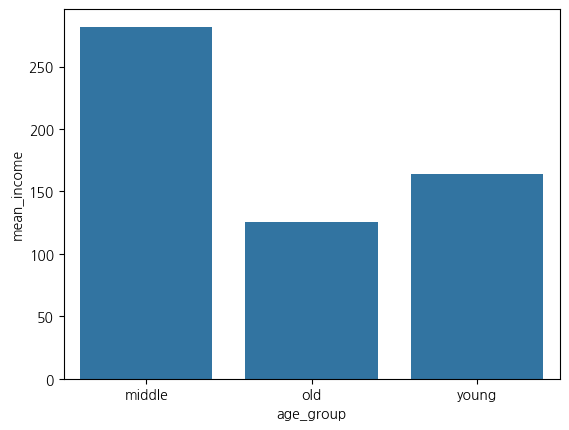

In [ ]:
# 막대 그래프 만들기
sns.barplot(x = 'age_group', y = 'mean_income', data = age_group_income)
plt.show()
# 추가 분석 진행 - 단순분산분석 & 사후검정

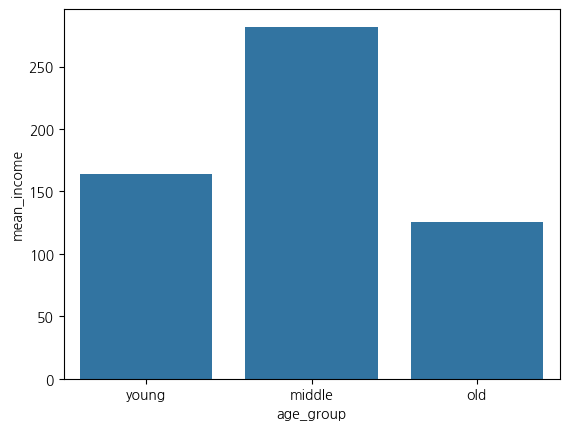

In [ ]:
# 막대 정렬하기
sns.barplot(x = 'age_group', y = 'mean_income',
            data = age_group_income, order = ['young', 'middle', 'old'])
plt.show()

# 중간 데이터 저장

In [ ]:
welfare.to_csv('/content/drive/MyDrive/lsda02/data/welfare_2015_0408.csv', index = False)

In [ ]:
# 데이터 불러오기
welfare = pd.read_csv('/content/drive/MyDrive/lsda02/data/welfare_2015_0408.csv')